In [ ]:
%%bash

rm -Rf train-images-idx3-ubyte.gz
rm -Rf train-labels-idx1-ubyte.gz 
wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

# Reading the labels

There are 10 possible handwritten digits: (0-9), therefore every label must be a number from 0 to 9. The file that we downloaded, `train-labels-idx1-ubyte.gz`, encodes labels as following:

### TRAINING SET LABEL FILE (train-labels-idx1-ubyte):

```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.
```

So it looks like the first 8 bytes (or the first 2 32-bit integers) can be skipped because they contain metadata of the file that is usually useful to lower-level programming languages.
To parse the file, we can perform the following operations:

- Open the file using the gzip library, so that we can decompress the file
- Read the entire byte array into memory
- Skip the first 8 bytes
- Iterate over every byte, and cast that byte to integer

NOTE: If this file was not from a trusted source, a lot more checking would need to be done. For the purpose of this blog post, I'm going to assume the file is valid in it's integrity.

In [1]:
import gzip

with gzip.open('train-labels-idx1-ubyte.gz') as train_labels:
    data_from_train_file = train_labels.read()

# Skip the first 8 bytes, we know exactly how many labels there are
label_data = data_from_train_file[8:]
assert len(label_data) == 60000

# Convert every byte to an integer. This will be a number between 0 and 9
labels = [int(label_byte) for label_byte in label_data]
assert min(labels) == 0 and max(labels) == 9
assert len(labels) == 60000


## Reading the images



```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  60000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
```

Reading images is slightly different than reading labels. The first 16 bytes contain metadata that we already know. We can skip those bytes and directly proceed to reading the images. Every image is represented as a 28*28 unsigned byte array. All we have to do is read one image at a time and save it into an array.

In [2]:
from typing import List

SIZE_OF_ONE_IMAGE = 28 ** 2

images: List[List[int]] = []

with gzip.open('train-images-idx3-ubyte.gz') as train_images:
    train_images.read(4 * 4)
    ctr = 0
    for _ in range(60000):
        image = train_images.read(size=SIZE_OF_ONE_IMAGE)
        assert len(image) == SIZE_OF_ONE_IMAGE
        images.append(image)

In [3]:
len(images)

60000

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image(pixels):
    plt.imshow(pixels.reshape((28, 28)), cmap='gray')
    plt.show()

In [5]:
images_np = np.array([np.frombuffer(image, dtype='uint8').reshape(SIZE_OF_ONE_IMAGE) / 255
                      for image in images])

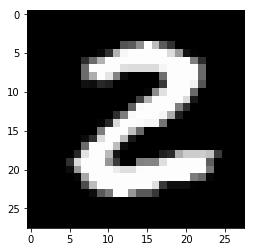

In [6]:
plot_image(images_np[25])

# Encoding image labels using one-hot encoding

In [7]:
labels_np = np.array(labels).reshape((-1, 1))

In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
labels_np_onehot = encoder.fit_transform(labels_np).toarray()

In [9]:
labels_np_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [10]:
labels_np_onehot[999]


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

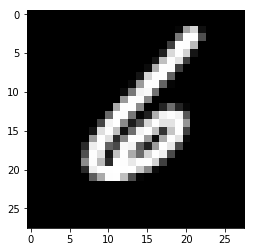

In [11]:
plot_image(images_np[999])

# Building train and test split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np_onehot)

In [13]:
y_train.shape

(45000, 10)

## Training a Neural Network using Keras

In [18]:
import tensorflow.keras as keras

model = keras.Sequential()
model.add(keras.layers.Dense(input_shape=(SIZE_OF_ONE_IMAGE,), units=128, activation='relu'))
model.add(keras.layers.Dense(input_shape=(SIZE_OF_ONE_IMAGE,), units=128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
45000/45000 [==============================] - 9s 194us/step - loss: 1.4267 - acc: 0.6580
Epoch 2/20
45000/45000 [==============================] - 8s 186us/step - loss: 0.5896 - acc: 0.8558
Epoch 3/20
45000/45000 [==============================] - 8s 185us/step - loss: 0.4353 - acc: 0.8835
Epoch 4/20
45000/45000 [==============================] - 8s 185us/step - loss: 0.3745 - acc: 0.8962
Epoch 5/20
45000/45000 [==============================] - 9s 193us/step - loss: 0.3407 - acc: 0.9033
Epoch 6/20
45000/45000 [==============================] - 10s 220us/step - loss: 0.3177 - acc: 0.9099
Epoch 7/20
45000/45000 [==============================] - 11s 235us/step - loss: 0.3005 - acc: 0.9147
Epoch 8/20
45000/45000 [==============================] - 9s 203us/step - loss: 0.2866 - acc: 0.9181
Epoch 9/20
45000/45000 [==============================] - 9s 197us/step - loss: 0.2743 - acc: 0.9218
Epoch 10/20
45000/45000 [==============================] - 9s 195us/step - loss: 0.2637 -

In [20]:
model.evaluate(X_test, y_test)

15000/15000 [==============================] - 2s 132us/step


[0.21733258232673008, 0.9374666666348775]

# Inspecting the results

Congratulations! you just trained a neural network to predict handwritten digits with 93.7% accuracy! Let's test out the network with one of the pictures we have in our testset

Let's take a random image, in this case the image at index `1010`. We take the predicted label (in this case, the value is a 6 because the 7th index is set to 1)

In [21]:
y_test[1010]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Let's plot the image of the corresponding image

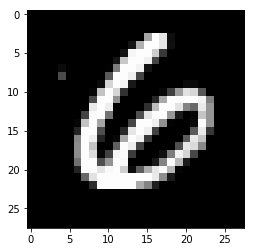

In [32]:
plot_image(X_test[1010])

### Understanding the output of a softmax activation layer

Now, let's run this nuber through the neural network and we can see what our predicted output looks like!

In [49]:
predicted_results = model.predict(X_test[1010].reshape((1, -1)))

The output of a softmax layer is a probability distribution for every output. In our case, there are 10 possible outputs (digits 0-9). Of course, every one of our images is expected to only match one specific output (in other words, all of our images only contain one distinct digit).

Because this is a probability distribution, the sum of the predicted results is 1.0

In [47]:
predicted_results.sum()

1.0

### Reading the output of a softmax activation layer for our digit

As you can see below, the 7th index is really close to 1 (0.9) which means that there is a 90% probability that this digit is a 6... which it is! congrats!

In [50]:
predicted_results

array([[4.4938503e-03, 9.2362927e-05, 2.6266586e-02, 6.4845401e-05,
        2.1520416e-04, 1.5977553e-04, 9.0274137e-01, 3.9823781e-06,
        6.5730967e-02, 2.3103080e-04]], dtype=float32)

# Viewing the confusion matrix

In [70]:
from sklearn.metrics import confusion_matrix

predicted_outputs = np.argmax(model.predict(X_test), axis=1)
expected_outputs = np.argmax(y_test, axis=1)

predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)

In [71]:
predicted_confusion_matrix

array([[1440,    0,    8,    2,    2,   11,    8,    0,    9,    4],
       [   0, 1678,    8,    6,    2,    1,    1,    0,   11,    3],
       [   6,   13, 1342,   14,   20,    3,   18,   18,   23,    4],
       [   5,    5,   27, 1408,    1,   35,    4,   11,   20,   17],
       [   4,    5,   11,    1, 1379,    1,   15,    1,    6,   49],
       [   9,    8,   11,   33,   11, 1260,   17,    2,   16,   17],
       [   7,    5,   11,    0,   11,   10, 1457,    0,   11,    0],
       [   7,   10,   22,    6,   14,    3,    0, 1431,    7,   27],
       [   4,   20,   18,   27,    9,   16,    7,    1, 1382,   19],
       [  11,    8,    1,   17,   48,    4,    2,   25,   13, 1285]])

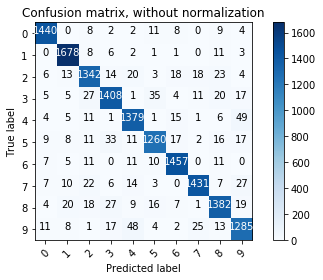

In [73]:
import itertools


# Source code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
class_names = [str(idx) for idx in range(10)]
cnf_matrix = confusion_matrix(expected_outputs, predicted_outputs)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()